Create figure showing scatter plot of E-P versus column integrated $Q_m$ and $Q_m^+$.

In [1]:
import loaders
import xarray as xr
from datetime import timedelta
from vcm.fv3.metadata import gfdl_to_standard
import zarr
import fsspec
import numpy as np
import vcm
import matplotlib.pyplot as plt
import fv3viz
import cartopy.crs as ccrs
from dask.distributed import Client
import string
plt.rcParams['figure.dpi'] = 250
xr.set_options(keep_attrs=True)

In [2]:
Client()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 29.39 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40299,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 29.39 GiB
Comm: tcp://127.0.0.1:45159,Total threads: 2
Dashboard: http://127.0.0.1:36167/status,Memory: 7.35 GiB
Nanny: tcp://127.0.0.1:37391,


In [3]:
def make_square(ax):
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    min_lim = min(xlim[0], ylim[0])
    max_lim = max(xlim[1], ylim[1])
    ax.set_xlim([min_lim, max_lim])
    ax.set_ylim([min_lim, max_lim])
    ax.plot([min_lim, max_lim], [min_lim, max_lim], '-r', linewidth=0.8, label='1:1')

In [4]:
def plot_fit(ax, fit, r2=None, rmse=None):
    label = f'best fit (r$^2$={r2:.2f}\nRMSE={rmse:.2f}mm/day)' if r2 else 'best fit'
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    ax.plot(xlim, np.array(xlim) * fit[0] + fit[1], '-y', linewidth=0.8, label=label)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

In [5]:
def scatter_plots(data, pairs):
    dims = ['time', 'tile', 'x', 'y']

    fig, axes = plt.subplots(1, len(pairs), figsize=(4 * len(pairs), 3))
    subtitles = [f'{x})' for x in string.ascii_lowercase[:len(pairs)]]
    for i, (x_name, y_name) in enumerate(pairs):
        x = data[x_name].transpose(*dims).values.ravel()
        y = data[y_name].transpose(*dims).values.ravel()
        fit = np.polyfit(x, y, 1)
        r2 = np.corrcoef(x, y)[0, 1] ** 2
        rmse = np.sqrt(np.mean((y - x)**2))
        nmse = np.mean((y-x)**2) / np.mean((y-np.mean(y))**2)
        print(nmse)

        # make scatter plots
        hb = axes[i].hexbin(x, y, bins='log', mincnt=1)
        axes[i].set_xlabel(data[x_name].long_name + f' [{data[x_name].units}]')
        axes[i].set_ylabel(data[y_name].long_name + f' [{data[y_name].units}]')
        if y_name != 'delta_Q2_dyn':
            make_square(axes[i])
            plot_fit(axes[i], fit, r2=r2, rmse=rmse)
            axes[i].legend(loc='lower right', frameon=False, fontsize=8)
        else:
            axes[i].grid(alpha=0.2, color='grey', linewidth=1)
        axes[i].text(0.04, 0.9, subtitles[i], transform=axes[i].transAxes)
        cb = fig.colorbar(hb, ax=axes[i], label='count')

    fig.tight_layout()

In [6]:
fine_res_url = 'gs://vcm-ml-experiments/default/2021-12-16/2020-05-27-40-day-X-SHiELD-simulation-v2/fine-res-budget.zarr'
grid_url = 'gs://vcm-ml-intermediate/latLonArea/c48/c48.zarr'
additional_dataset_urls = [
    'gs://vcm-ml-experiments/default/2022-01-27/n2f-prescribe-t-nudge-apparent-sources-only-long/fv3gfs_run/nudging_tendencies.zarr',
    'gs://vcm-ml-experiments/default/2022-01-27/n2f-prescribe-t-nudge-apparent-sources-only-long/fv3gfs_run/state_after_timestep.zarr',
]
Lv = 2.5e6

In [7]:
effective_sources = loaders.open_fine_resolution(
    approach='apparent_sources_plus_nudging_tendencies',
    fine_url=fine_res_url,
    include_temperature_nudging=True,
    additional_dataset_urls=additional_dataset_urls,
).data

In [8]:
apparent_sources = loaders.open_fine_resolution(
    approach='apparent_sources_only',
    fine_url=fine_res_url,
    include_temperature_nudging=True,
    additional_dataset_urls=additional_dataset_urls,
).data

In [9]:
for ds in [effective_sources, apparent_sources]:
    delp = ds.pressure_thickness_of_atmospheric_layer
    ds['column_integrated_Q2'] = vcm.mass_integrate(ds.Q2, delp, dim='z')
    ds['delta_Q2_dyn'] = vcm.mass_integrate(ds.specific_humidity_tendency_due_to_nudging, delp, dim='z')
    ds['delta_Q2_dyn'].attrs['long_name'] = '$<\Delta Q_q^{dyn}>$'
    ds['E_minus_P'] = ds.LHTFLsfc_coarse / Lv - ds.PRATEsfc_coarse
    ds['E_minus_P'].attrs['long_name'] = 'E - P'
    for variable in ['column_integrated_Q2', 'E_minus_P', 'delta_Q2_dyn']:
        ds[variable] *= 86400
        ds[variable].attrs['units'] = 'mm/day'

In [10]:
apparent_sources['column_integrated_Q2'].attrs['long_name'] = '$<Q_q>$'
effective_sources['column_integrated_Q2'].attrs['long_name'] = '$<Q^+_q>$'

In [11]:
data_to_plot = xr.merge(
    [
        apparent_sources.E_minus_P,
        apparent_sources.column_integrated_Q2,
        effective_sources.column_integrated_Q2.rename('column_integrated_Q2_plus'),
        effective_sources.delta_Q2_dyn,
    ]
).isel(time=slice(None, None, 5))

In [12]:
data_to_plot

<xarray.Dataset>
Dimensions:                    (time: 168, tile: 6, y: 48, x: 48)
Coordinates:
  * time                       (time) object 2016-08-05 01:00:00 ... 2016-09-...
Dimensions without coordinates: tile, y, x
Data variables:
    E_minus_P                  (time, tile, y, x) float64 dask.array<chunksize=(1, 6, 48, 48), meta=np.ndarray>
    column_integrated_Q2       (time, tile, y, x) float64 dask.array<chunksize=(1, 6, 48, 48), meta=np.ndarray>
    column_integrated_Q2_plus  (time, tile, y, x) float64 dask.array<chunksize=(1, 6, 48, 48), meta=np.ndarray>
    delta_Q2_dyn               (time, tile, y, x) float64 dask.array<chunksize=(1, 6, 48, 48), meta=np.ndarray>
Attributes:
    cell_methods:  time: point
    long_name:     E - P
    units:         mm/day

In [13]:
data_to_plot = data_to_plot.compute()

0.1027749024654779
0.42095492096310894


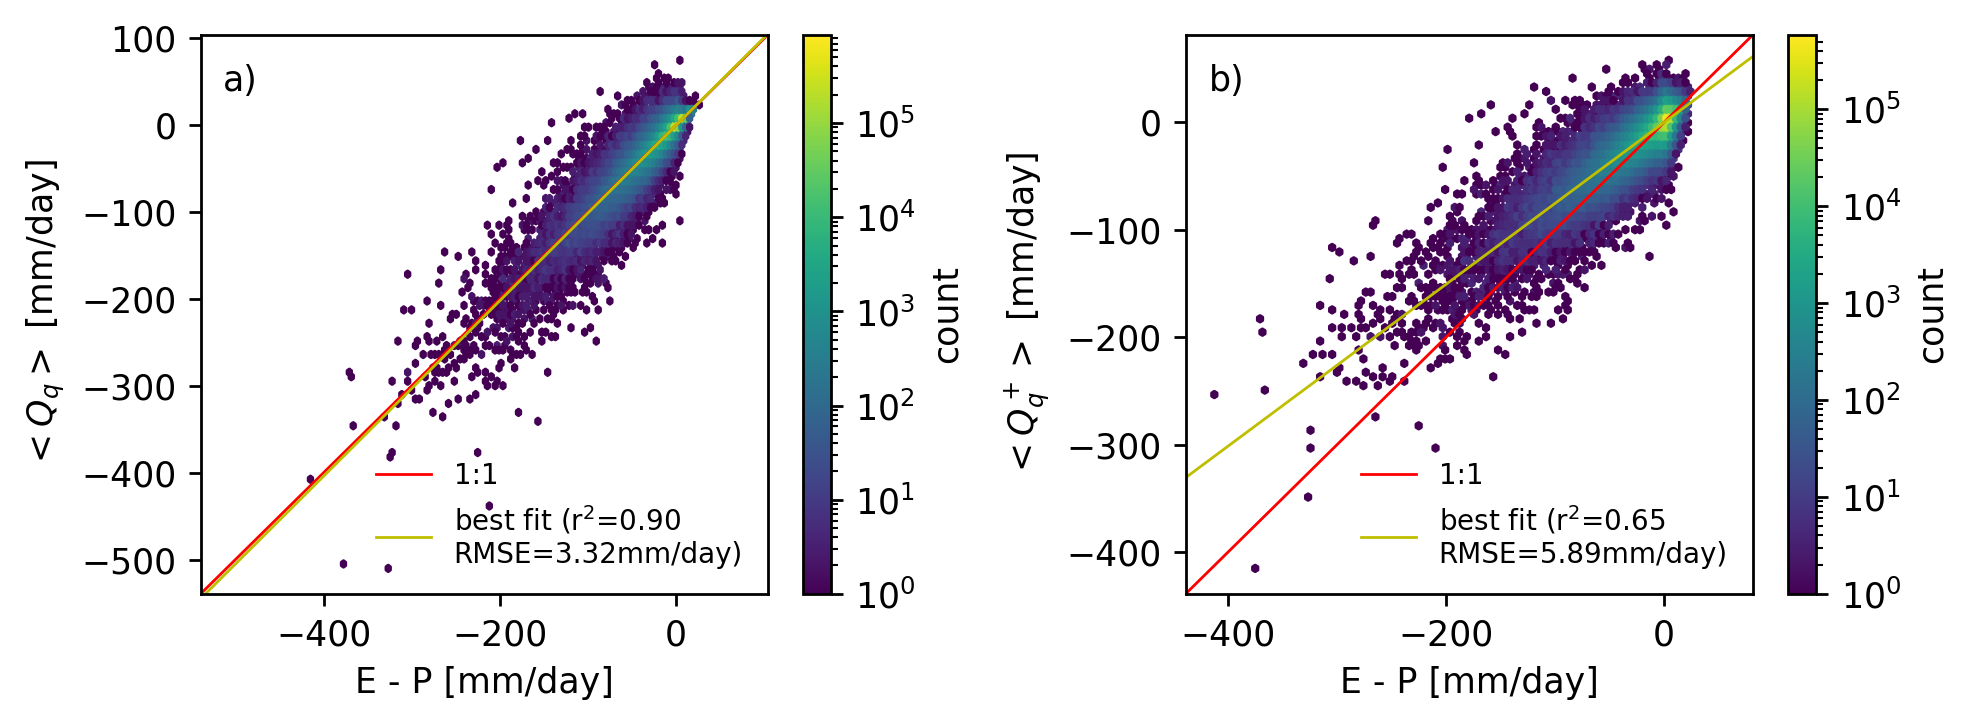

In [14]:
scatter_plots(
    data_to_plot,
    [
        ('E_minus_P', 'column_integrated_Q2'),
        ('E_minus_P', 'column_integrated_Q2_plus'),
    ]
)

0.42095492096310894
6.440228019237526


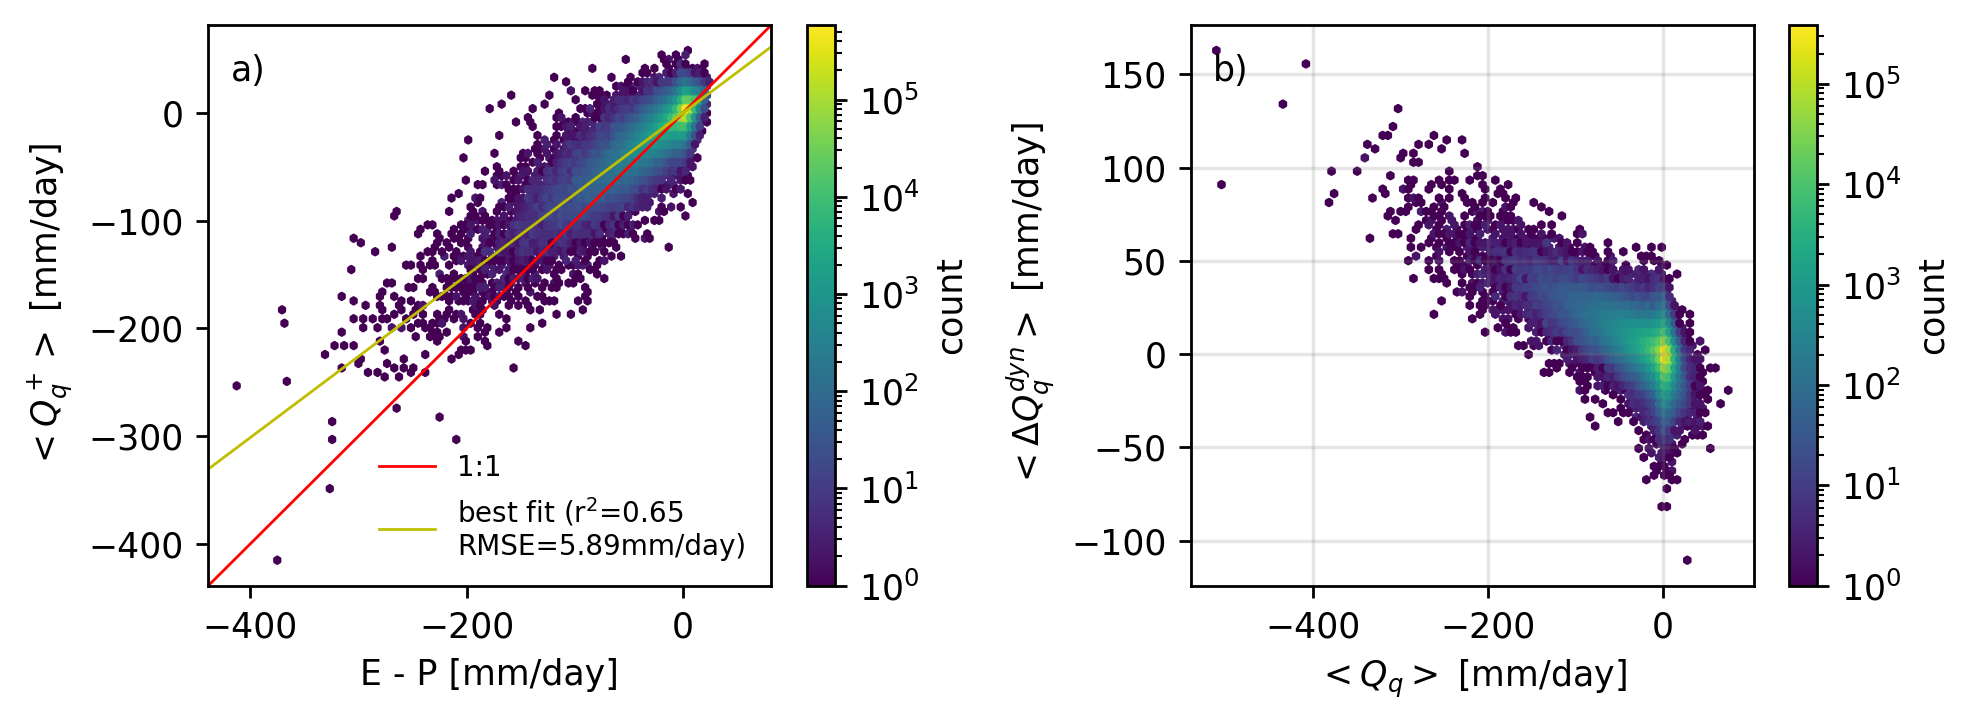

In [15]:
scatter_plots(
    data_to_plot, 
    [
        ('E_minus_P', 'column_integrated_Q2_plus'),
        ('column_integrated_Q2', 'delta_Q2_dyn'),
    ]
)